In [1]:
#! pip install seaborn
#! pip install matplotlib

In [2]:
import lifesim
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
bus = lifesim.Bus()
# bus holds parameters needed for the simulation

In [4]:
# Can use predefined scenarios such as 'baseline', 'optimistic' or 'pessimistic'
bus.data.options.set_scenario('baseline')

# or set it manaually using set_manual(*=*)

In [5]:
# ! pip install request

In [6]:
import requests

# Downloading synthetic planet population from P-Pop
data = requests.get('https://raw.githubusercontent.com/kammerje/P-pop/main/TestPlanetPopulation.txt')

with open('ppop_catalog.txt', 'wb') as file:
    file.write(data.content)

In [7]:
# Loading catalog into LIFEsim

bus.data.catalog_from_ppop(input_path='ppop_catalog.txt')

# Removing all A-type stars and M-type stars further than 10pc
bus.data.catalog_remove_distance(stype='A', mode='larger', dist=0.)
bus.data.catalog_remove_distance(stype='M', mode='larger', dist=10.)

# 0 = A, 1 = F, 2 = G, 3 = K, 4 = M

Processed line 45884 of 45884


In [8]:
# Creating an LIFEsim instrument
instrument = lifesim.Instrument(name='inst')

# Connecting to the bus to access data and parameters
bus.add_module(instrument)

In [9]:
# Creating and adding to the bus a module that simulates transmission maps of a four-arm nulling interferometer
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

#Creating and adding to the bus modules for the simulation of the astrophysical noise sources
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)

In [10]:
# Connecting the instrument to the modules
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))

bus.connect(('star', 'transm'))

In [11]:
# optimizer distributes the available observing time onto the individual stars
opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)

bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))

In [12]:
# Calculate signal-to-noise ratio for every planet in the catalog
instrument.get_snr()

# Assigns SNR after one hour of observation. I the random noise case, SNR scales with square-root of the integration time
# Distributing the integration time for each planet,
opt.ahgs()

# Baseline case -- the observation time is distributed such that the number of planets in the habitable zone around their respective host stars is optimized.

100%|█████████████████████████████████████████| 535/535 [06:18<00:00,  1.41it/s]


Number of planets detected by stellar type:
A: 0.0  F: 0.5  G: 2.8  K: 13.4  M: 21.7  -  (2.0 / 2.0) yrs observed


In [13]:
# Number of detected exoplanets in the habitable zone around M-type stars
mask_mtype = bus.data.catalog.stype == 4
mask = np.logical_and.reduce((bus.data.catalog.detected, bus.data.catalog.habitable, mask_mtype))
result_number = mask.sum()/500
result_number

0.0

In [20]:
# Saving the results
# bus.data.options.set_manual(output_filename='results')
# bus.save()
bus.data.catalog.to_csv('results.csv')

In [15]:
# Reading results into LIFEsim
# bus_read = lifesim.Bus()
# bus_read.data.options.set_scenario('baseline')
# bus_read.data.import_catalog(input_path='results.hdf5')

In [16]:
df = bus.data.catalog
df_notfloat = df.columns[(df.dtypes.values != np.dtype('float64'))]
for i in range(len(df_notfloat)):
    df[df_notfloat[i]] = df[df_notfloat[i]].astype('category').cat.codes

In [17]:
# Correlation matrix between the features
corr_matrix = df.corr()
corr_matrix

,radius_p,p_orb,mass_p,ecc_p,inc_p,large_omega_p,small_omega_p,theta_p,albedo_bond,albedo_geom_vis,...,hz_in,hz_out,hz_center,habitable,snr_1h,baseline,detected,snr_current,int_time,t_slew
radius_p,1.000000,0.060154,0.233736,NaN,-0.011677,0.004711,-0.008127,-0.002783,-0.004725,-0.006150,...,0.015707,0.016638,0.016354,-0.218448,0.434055,-0.020561,0.130314,0.275795,-0.026006,-0.021073
p_orb,0.060154,1.000000,0.022246,NaN,0.001964,0.016534,0.003619,-0.006077,-0.005634,0.003135,...,0.011497,0.011754,0.011677,0.147501,-0.120781,-0.011824,-0.223162,-0.097501,0.001369,-0.008036
mass_p,0.233736,0.022246,1.000000,NaN,0.006376,0.006804,0.006553,-0.000637,-0.008731,-0.009113,...,-0.008800,-0.008932,-0.008892,-0.015348,0.079223,0.007142,0.001026,0.022915,0.001328,-0.004637
ecc_p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inc_p,-0.011677,0.001964,0.006376,NaN,1.000000,-0.009826,0.005399,-0.002307,-0.000720,-0.011130,...,-0.007007,-0.007649,-0.007452,0.000448,-0.018346,0.006085,0.010616,0.006818,0.023325,0.021560
large_omega_p,0.004711,0.016534,0.006804,NaN,-0.009826,1.000000,-0.008723,0.003562,-0.007828,0.005264,...,-0.006508,-0.006412,-0.006443,-0.004013,0.004081,0.011699,-0.007497,0.011308,0.000987,0.003501
small_omega_p,-0.008127,0.003619,0.006553,NaN,0.005399,-0.008723,1.000000,-0.013251,0.008850,-0.002356,...,0.003797,0.003507,0.003596,0.007174,-0.006004,0.003229,0.001581,-0.004818,0.025383,0.021208
theta_p,-0.002783,-0.006077,-0.000637,NaN,-0.002307,0.003562,-0.013251,1.000000,0.015044,0.012196,...,0.005326,0.005290,0.005302,0.012007,0.004573,-0.007962,0.004513,-0.004055,-0.005502,0.000032
albedo_bond,-0.004725,-0.005634,-0.008731,NaN,-0.000720,-0.007828,0.008850,0.015044,1.000000,0.002917,...,0.006070,0.005824,0.005900,-0.018924,-0.086077,-0.007836,-0.087581,-0.060667,-0.004931,-0.002860
albedo_geom_vis,-0.006150,0.003135,-0.009113,NaN,-0.011130,0.005264,-0.002356,0.012196,0.002917,1.000000,...,0.011550,0.011723,0.011672,0.001733,-0.010957,-0.004004,0.001132,0.002742,0.004585,-0.003613


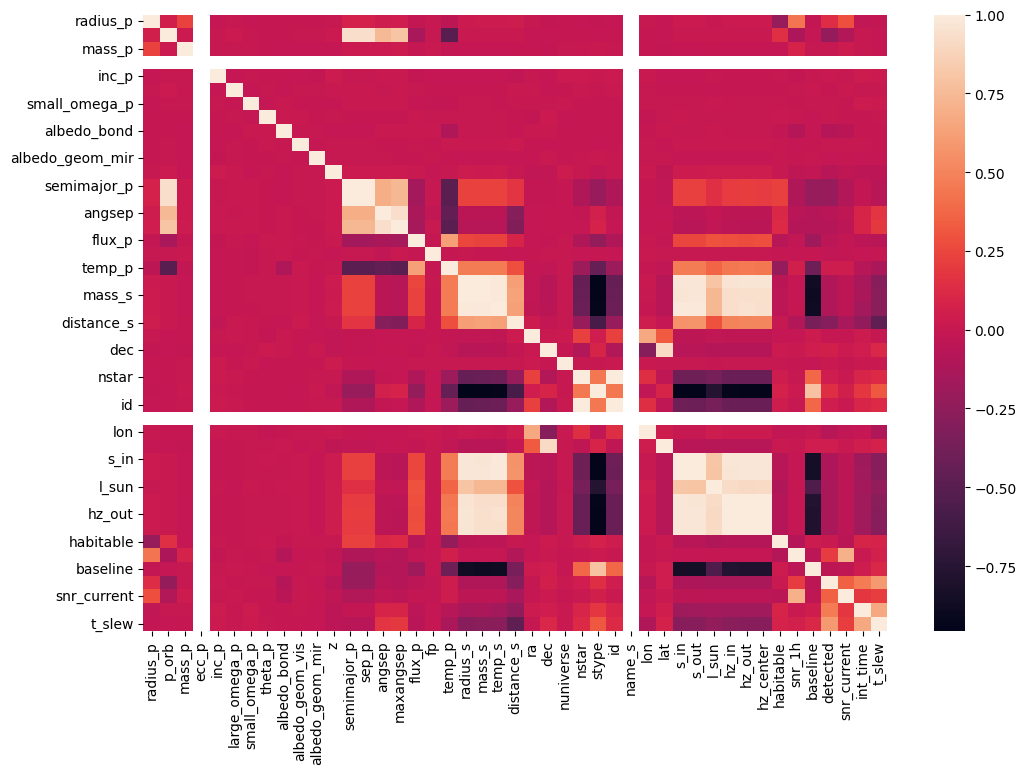

In [18]:
plt.figure(figsize=(12,8))
sn.heatmap(corr_matrix)
plt.show()

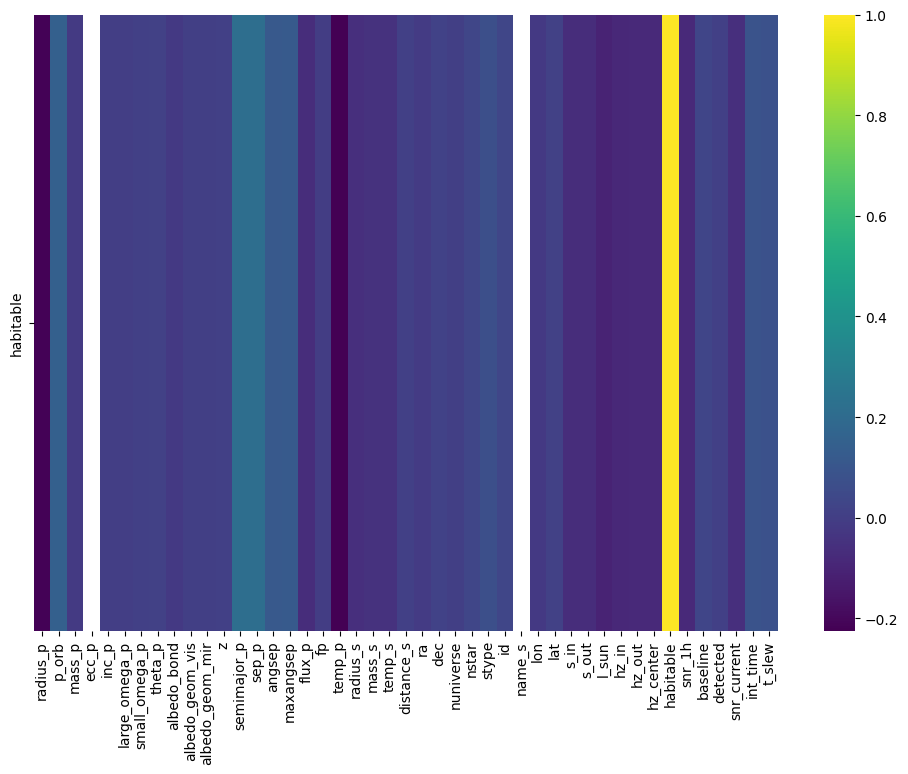

In [19]:
habit = pd.DataFrame(corr_matrix['habitable'], index = corr_matrix['habitable'].index)

plt.figure(figsize=(12,8))
sn.heatmap(habit.transpose(), fmt="g", cmap='viridis') #annot=True,
plt.show()

'nuniverse' : The index for the universe the planet is located in. See ‘Important’ box above for further explanation.

'nstar' : The unique index for the star.

'habitable' : Is True if the planet resides in the habitable zone of its host star.

'snr_1h' : The signal-to-noise ration the planet would have after one hour of integration time.

'detected': Is True if the planet is observed long enough to have an SNR larger than bus.data.option.optimization[‘snr_target’]. In this case, the planet is counted towards the planets detected in the search phase.

'int_time': The amount of integration time spend on the system in [s].